## CS985: Machine Learning for Data Analytics: Assignment 1
#### Group 35: Tim Hortons  
1. Olivier Delree: 202278679   
2. Rowan Craig: 202253594  
3. Eilidh Pike: 202274131  
4. Aparna Asokan: 202251020  

### Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing the training dataset
train_original_df = pd.read_csv("CS98XRegressionTrain.csv")

The following dataset was taken from Spotify (available here: https://www.kaggle.com/datasets/cnic92/spotify-past-decades-songs-50s10s). <br>

Below is a list of the attributes given for each song in the dataset and the corresponding column title.

- id: unique identifier
- title: track title
- artist: song artist
- top genre: genre of the track
- year: year of release (or re-release) 
- bpm: tempo (beats per minute)
- nrgy: the higher the value the more energetic (energy)
- dnce: the higher the value, the easier it is to dance to this song (danceability)
- dB: the higher the value, the louder the song (loudness, decibels)
- live: the higher the value, the more likely the song is a live recording (liveness)
- val: the higher the value, the more positive mood for the song (valence)
- dur: the length of the song (duration)
- acous: the higher the value the more acoustic the song is (acousticness)
- spch: the higher the value the more spoken word the song contains (speechiness)
- pop: the higher the value the more popular the song is (popularity)

The focus of this regression task is to predict the pop value of new observations.


We dropped the 'Id' column as this does not have any relevance when predicting a popularity value.

In [ ]:
train_original_df.drop(columns=["Id"], inplace=True)

The below columns have been renamed to improve readability.

In [ ]:
train_original_df.rename(columns={"title": "Title",
                                  "artist": "Artist",
                                  "top genre": "Genre",
                                  "year": "Year",
                                  "bpm": "Tempo",
                                  "nrgy": "Energy",
                                  "dnce": "Danceability",
                                  "dB": "Loudness",
                                  "live": "Liveness",
                                  "val": "Positivity",
                                  "dur": "Duration",
                                  "acous": "Acousticness",
                                  "spch": "Speechiness",
                                  "pop": "Popularity"}, inplace=True)

##### Summary Statistics

Generating summary statistics to check for null values and ensure that the data types of the variables are in line with what was expected. 

In [ ]:
train_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         453 non-null    object
 1   Artist        453 non-null    object
 2   Genre         438 non-null    object
 3   Year          453 non-null    int64 
 4   Tempo         453 non-null    int64 
 5   Energy        453 non-null    int64 
 6   Danceability  453 non-null    int64 
 7   Loudness      453 non-null    int64 
 8   Liveness      453 non-null    int64 
 9   Positivity    453 non-null    int64 
 10  Duration      453 non-null    int64 
 11  Acousticness  453 non-null    int64 
 12  Speechiness   453 non-null    int64 
 13  Popularity    453 non-null    int64 
dtypes: int64(11), object(3)
memory usage: 49.7+ KB


Calculating the percentage of values which are Null, to inform further data cleaning. 

In [ ]:
genre_percent_missing = train_original_df.Genre.isnull().sum() / len(train_original_df)
print(f"{genre_percent_missing = :.2%}")

genre_percent_missing = 3.31%


As it is only 3.3% of the values in 'Genre' which are Null, we conclude that these can be removed without compromising the training of the models.

In [ ]:
train_original_df.dropna(inplace=True)

Checking for duplicates showed that there is one duplicate value, so this must be dropped. The shape of the DataFrame at this point is demonstrated below. 

In [ ]:
print(sum(train_original_df.duplicated()))

1


The shape below demonstrates that the duplicate row was removed. 

In [ ]:
print(f"Shape before removing duplicates: {train_original_df.shape}")
train_original_df.drop_duplicates(inplace=True)
print(f"Shape after removing duplicates: {train_original_df.shape}")

Shape before removing duplicates: (438, 14)
Shape after removing duplicates: (437, 14)


##### Checking Distribution of Variables

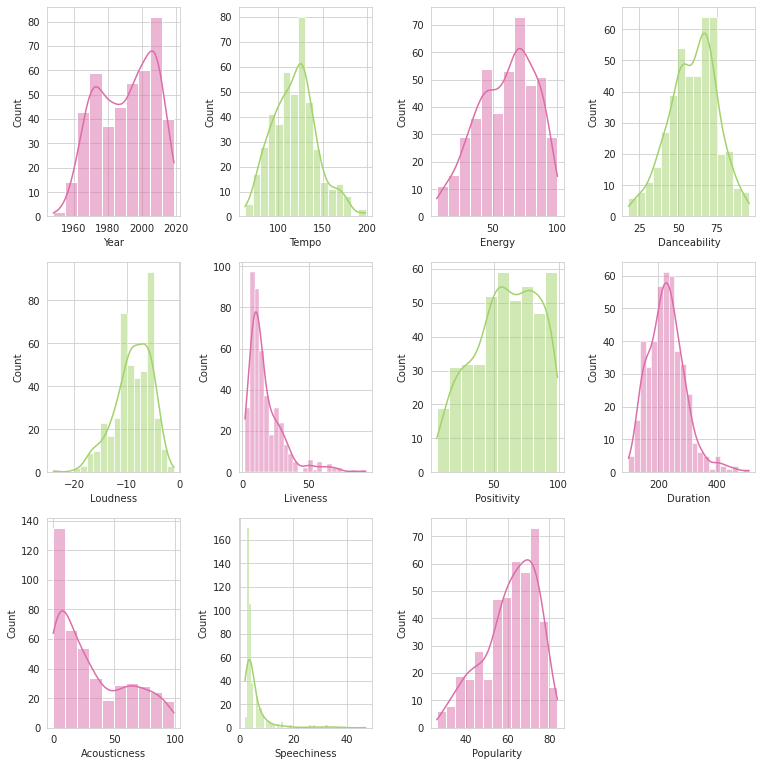

In [ ]:
f, axes = plt.subplots(3, 4, figsize=(11, 11))
f.tight_layout(pad=2.5)
sns.set_style('whitegrid')
sns.histplot(train_original_df["Year"], ax=axes[0, 0], color='#DB6DA8', kde=True)
sns.histplot(train_original_df["Tempo"], ax=axes[0, 1], color='#A1D26B', kde=True)
sns.histplot(train_original_df["Energy"], ax=axes[0, 2], color='#DB6DA8', kde=True)
sns.histplot(train_original_df["Danceability"], ax=axes[0, 3], color='#A1D26B', kde=True)
sns.histplot(train_original_df["Loudness"], ax=axes[1, 0], color='#A1D26B', kde=True)
sns.histplot(train_original_df["Liveness"], ax=axes[1, 1], color='#DB6DA8', kde=True)
sns.histplot(train_original_df["Positivity"], ax=axes[1, 2], color='#A1D26B', kde=True)
sns.histplot(train_original_df["Duration"], ax=axes[1, 3], color='#DB6DA8', kde=True)
sns.histplot(train_original_df["Acousticness"], ax=axes[2, 0], color='#DB6DA8', kde=True)
sns.histplot(train_original_df["Speechiness"], ax=axes[2, 1], color='#A1D26B', kde=True)
sns.histplot(train_original_df["Popularity"], ax=axes[2, 2], color='#DB6DA8', kde=True)
f.delaxes(axes[2][3])
plt.show()

##### Checking for Outliers

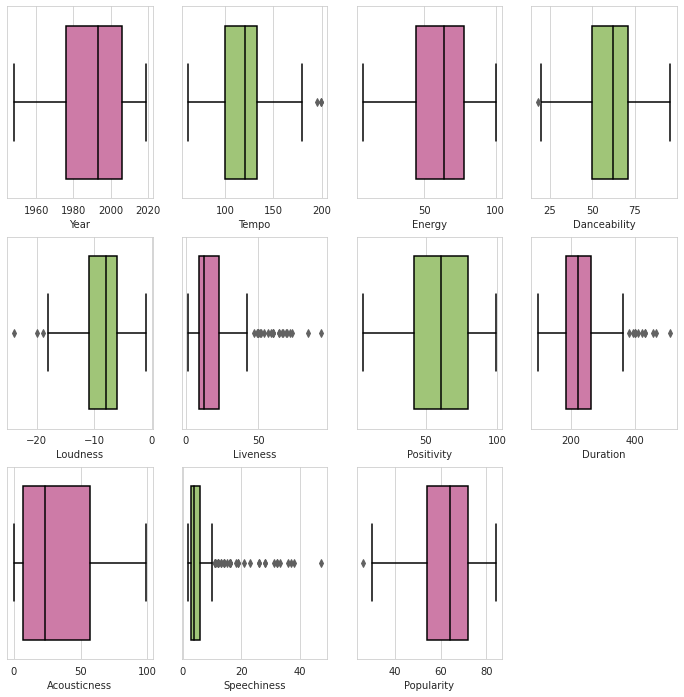

In [ ]:
props = {'whiskerprops':{'color':'black'},'boxprops':{'edgecolor':'black'},'capprops':{'color':'black'},
         'medianprops':{'color':'black'}}
f, axes = plt.subplots(3, 4, figsize=(12, 12))
sns.set_style('whitegrid')
sns.boxplot(train_original_df["Year"], ax=axes[0, 0], color='#DB6DA8', **props)
sns.boxplot(train_original_df["Tempo"], ax=axes[0, 1], color='#A1D26B', **props)
sns.boxplot(train_original_df["Energy"], ax=axes[0, 2], color='#DB6DA8', **props)
sns.boxplot(train_original_df["Danceability"], ax=axes[0, 3], color='#A1D26B', **props)
sns.boxplot(train_original_df["Loudness"], ax=axes[1, 0], color='#A1D26B', **props)
sns.boxplot(train_original_df["Liveness"], ax=axes[1, 1], color='#DB6DA8', **props)
sns.boxplot(train_original_df["Positivity"], ax=axes[1, 2], color='#A1D26B', **props)
sns.boxplot(train_original_df["Duration"], ax=axes[1, 3], color='#DB6DA8', **props)
sns.boxplot(train_original_df["Acousticness"], ax=axes[2, 0], color='#DB6DA8', **props)
sns.boxplot(train_original_df["Speechiness"], ax=axes[2, 1], color='#A1D26B', **props)
sns.boxplot(train_original_df["Popularity"], ax=axes[2, 2], color='#DB6DA8', **props)
f.delaxes(axes[2][3])
plt.show()

The above boxplots demonstrate that there are outliers within the Liveness, Duration and Speechiness columns. 
It is, however, shown in the histograms above that these variables all have leptokurtic distributions with positive (right) skew. We opt not to remove these outliers as it is a small dataset and we have already dropped 15 missing values and these actions together could affect the strength of the models. 

##### Relationship Hypotheses

The data does not appear linearly separable in most cases and so further specific analyses between variables must take place. 

Upon study of the dataset provided, we hypothesise that:

1. Louder songs are more popular. 
2. Livelier songs are more popular. 
3. Songs with more speechiness could be less popular. 
4. Songs with higher danceability are more popular. 
5. Variables such as year may not have much importance when determining popularity of a song. 
6. Songs by certain artists are more popular. 
7. Energetic songs are more lively and thus more popular. 
8. Acoustic songs may be less popular. 
9. Shorter songs may be more popular. 

##### Investigations

Creating a heatmap to demonstrate the correlations between variables, as a value between -1 and 1. 

Text(0.5, 1.0, 'Correlational Heatmap')

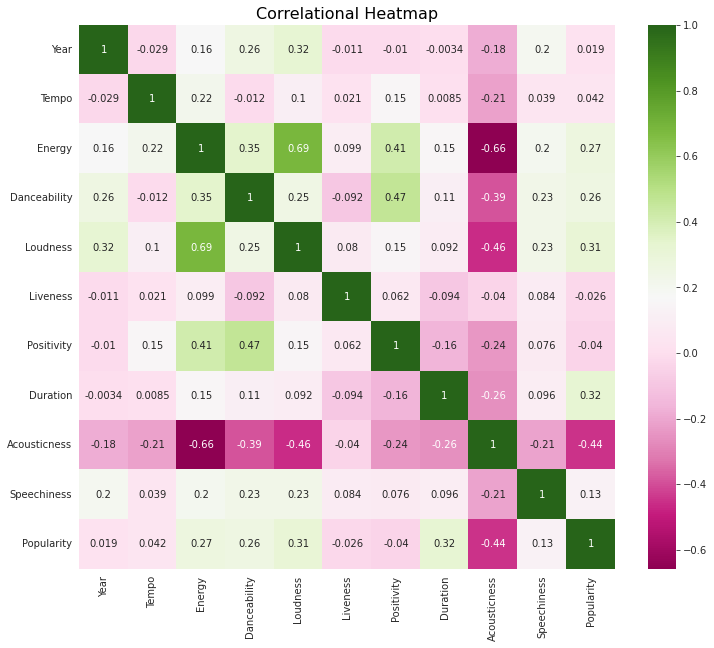

In [ ]:
corr = train_original_df.corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2g', cmap='PiYG')
plt.title('Correlational Heatmap', size=16, c='black')

From the above heatmap/correlation plot, a list of all significant correlations with popularity are detailed below:

- Popularity and Accousticness (-0.44)
- Popularity and Duration (0.32)
- Popularity and Loudness (0.31)
- Popularity and Energy (0.27)
- Popularity and Danceability (0.26)

Acousticness, Loudness, Danceability, and Energy are all multicollinear and so these variables (excluding Acousticness) are dropped. Acousticness has the strongest correlation with Popularity, so this has been kept in the dataset for further analyses and model training. If left in the dataset, this could result in the scoring metrics being altered due to the strong correlations masking the true effectiveness of the model.


In [ ]:
train_prepared_df = train_original_df.drop(columns=['Energy', 'Positivity'])

### Regression Models

In [ ]:
train_linear_regression_df = train_prepared_df.drop(columns=['Title'])
genre_value_counts = dict(train_linear_regression_df.Genre.value_counts())
artist_value_counts = dict(train_linear_regression_df.Artist.value_counts())
artist_value_counts.update(genre_value_counts)
train_linear_regression_df.replace(artist_value_counts, inplace=True)

In [ ]:
attributes = train_linear_regression_df.drop(columns=['Popularity'])

min_max_scaler = preprocessing.MinMaxScaler()
attributes = pd.DataFrame(min_max_scaler.fit_transform(attributes), columns=attributes.columns)

outcome = train_linear_regression_df['Popularity']

In [ ]:
# Training the models
# Splitting the data for validation of the models
X_train, X_test, y_train, y_test = train_test_split(attributes, outcome)

##### Linear Regression #####
linReg = LinearRegression()
linReg.fit(X_train, y_train)

predictedLin = linReg.predict(X_test)
lin_reg_rmse = np.sqrt(metrics.mean_squared_error(y_test, predictedLin))
print(f"{lin_reg_rmse=:.2f}")

##### Support Vector Machine #####
svm_model = SVC()
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_predictions))
print(f"{svm_rmse=:.2f}")

##### Decision Tree Regressor #####
decision_tree_model = DecisionTreeRegressor(random_state=27, min_samples_leaf=185, min_samples_split=400)
decision_tree_model.fit(X_train, y_train)

decision_tree_predictions = decision_tree_model.predict(X_test)
decision_tree_rmse = np.sqrt(mean_squared_error(y_test, decision_tree_predictions))
print(f"{decision_tree_rmse=:.2f}")

##### Random Forest Regressor #####
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

random_forest_predictions = random_forest_model.predict(X_test)
random_forest_rmse = np.sqrt(mean_squared_error(y_test, random_forest_predictions))
print(f"{random_forest_rmse=:.2f}")

##### K-Nearest Neighbours Regressor #####
k_nearest_model = KNeighborsRegressor()
k_nearest_model.fit(X_train, y_train)

k_nearest_predictions = k_nearest_model.predict(X_test)
k_nearest_rmse = np.sqrt(mean_squared_error(y_test, k_nearest_predictions))
print(f"{k_nearest_rmse=:.2f}")

lin_reg_rmse=10.63
svm_rmse=12.00
decision_tree_rmse=12.50
random_forest_rmse=9.52
k_nearest_rmse=10.68


Given the previous RMSEs, the random forest regressor seems to most consistently produce the best results after running the models multiple times. Therefore, the random forest regressor is used to try to find a set of parameters that would improve the prediction RMSE using `GridSearchCV`.

`n_estimators` and `max_depth` are investigated here as they are the parameters that impact random forest regressor the most according to our tests.

In [ ]:
grid_search_random_forest = GridSearchCV(estimator=RandomForestRegressor(), param_grid={"n_estimators": range(100, 801, 100), 
                                                                                        "max_depth": range(2, 11)}, 
                                         scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search_random_forest.fit(X_train, y_train)

grid_search_predictions = grid_search_random_forest.predict(X_test)
grid_search_rmse = np.sqrt(mean_squared_error(y_test, grid_search_predictions))

print(f"Best parameters found by the grid search: {grid_search_random_forest.best_params_}")
print(f"{grid_search_rmse = :.2f}")

Best parameters found by the grid search: {'max_depth': 8, 'n_estimators': 300}
grid_search_rmse = 10.99


From the previous output, it is unfortunately apparent that tuning of the hyperparameters of the random forest regressor does not improve the prediction power of the model in any significant way.

In [ ]:
# This cell allows for writing the predictions of our baseline and best
# models to file.
# Set PREDICT_TEST to False to prevent that.
PREDICT_TEST = True

if PREDICT_TEST:
    # Importing and preparing the test dataset
    test_original_df = pd.read_csv("CS98XRegressionTest.csv")

    test_original_df.rename(columns={"title": "Title",
                                     "artist": "Artist",
                                     "top genre": "Genre",
                                     "year": "Year",
                                     "bpm": "Tempo",
                                     "nrgy": "Energy",
                                     "dnce": "Danceability",
                                     "dB": "Loudness",
                                     "live": "Liveness",
                                     "val": "Positivity",
                                     "dur": "Duration",
                                     "acous": "Acousticness",
                                     "spch": "Speechiness"},
                            inplace=True)
    test_prepared_df = test_original_df.drop(columns=["Id", "Energy", "Positivity", "Title"])

    artists_value_counts = dict(test_prepared_df.Artist.value_counts())
    genre_value_counts = dict(test_prepared_df.Genre.value_counts())
    artists_value_counts.update(genre_value_counts)
    test_prepared_df.replace(artists_value_counts, inplace=True)

    # One value of Genre is NaN, we replace it with the most common genre value count
    test_prepared_df.replace({np.NaN: max(genre_value_counts.values())}, inplace=True)

    min_max_scaler = preprocessing.MinMaxScaler()
    test_prepared_df = pd.DataFrame(min_max_scaler.fit_transform(test_prepared_df), columns=test_prepared_df.columns)

    # Generating predictions and exporting them to file
    test_linear_predictions = linReg.predict(test_prepared_df)
    test_linear_predictions = pd.Series(data=test_linear_predictions, index=test_original_df.Id, name="pop")
    test_linear_predictions.to_csv("CS98XRegressionTestLinearPredictions.csv")

    test_forest_predictions = grid_search_random_forest.predict(test_prepared_df)
    test_forest_predictions = pd.Series(data=test_forest_predictions, index=test_original_df.Id, name="pop")
    test_forest_predictions.to_csv("CS98XRegressionTestForestPredictions.csv")

### Conclusion
In conclusion, models trained on the Spotify dataset were put through 5 different models: linear regression, SVM, decision tree, random forest, and K-nearest neighbours.
Compared to the linear regression baseline, the random forest and K-nearest neighbours regressors performed better while SVM and decision tree regressor tended to perform on par or worse.

After uploading the predictions from our grid search random forest model, we obtained a score of 7.5912 compared to 9.0371 from linear regression.